In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.354665  0.745587 -0.253494 -0.439669  0.231925 -0.865231  0.435832   
  1  -0.116539  0.102261 -0.125983  0.794325  0.561888 -0.790168  1.204412   
  2  -0.772224  0.227005  0.268111  0.431681  0.028066  0.433915  0.832286   
  3   0.064628  0.278556  0.533504 -0.024112  0.689398 -0.512377 -0.242060   
  4   0.543666  0.608025 -0.806894 -0.851127 -0.426994  0.003865 -0.094121   
  5   0.754046  1.084053 -0.277755  0.808711  0.844074 -0.180962  0.376274   
  6   0.308243  1.014830  1.123267 -0.432942 -0.334542 -0.669231  1.089902   
  7  -0.621887  0.770649  0.155712  0.197789  0.758136 -1.758688 -1.347185   
  8  -0.063182  1.253926  0.782059 -0.008007 -0.199786 -0.655654 -1.104420   
  9   0.178324  0.762452  0.591865  0.233642 -0.897839 -0.101278 -0.289536   
  10  0.476135  0.605365  0.599590  0.370742 -0.000463 -0.132138 -0.318923   
  11  0.085475  0.092622 -0.038821 -0.086769  0.076865 -0.952668 -0.711011   
  12 -0.308348  0.477498  0.450504  0.156149  0.227427 -1.015501  0.702536   
  13  0.545269  0.805799 -0.101585 -0.749342 -0.756098 -1.418156 -0.780400   
  14  0.252441  1.128230  0.243723  0.639117 -0.290122 -1.431704  0.694566   
  15 -0.485548  0.130311  0.657260  0.481726  0.913145 -0.525509  0.190965   
  16 -0.370046  0.864703  0.431175  0.106895  0.409085 -0.124050 -0.120206   
  17 -0.434832  0.184497  0.061814 -0.654166  0.098230 -0.209326  0.542590   
  18 -0.205344  1.150883  0.726597  0.938122 -0.549307 -0.254456 -0.912531   
  19  0.345938  0.399875  0.369852 -0.099134  0.100047 -0.740904  0.199623   
  20  1.041082  0.442476 -0.232103 -0.189167 -0.108566  0.379716 -0.377360   
  21  0.333466  0.610954  0.734673  0.635773  0.289260 -0.449197  0.473213   
  22  0.344343  1.491815  0.614615  0.329756  0.449334 -1.065855 -0.114012   
  23 -0.261672 -0.054545 -0.322709 -0.143052  0.305980 -1.309473 -1.097608   
  24  0.129360  1.152026  0.476132  0.364793  0.879401 -0.184545  0.903380   
1 0  -1.276118 -0.624136 -0.454712 -0.502988  0.539318  0.600480  0.306465   
  1  -0.736308 -0.401067 -0.263727 -0.574977 -0.259528 -0.719937  0.028692   
  2  -1.175129  0.105004  0.563045 -0.904031  0.185932  0.025594  0.315895   
  3  -0.607820  0.045948 -0.726199 -1.348806  0.657542  0.088417  0.533789   
  4  -0.048271 -0.858365 -0.217674 -0.071080  0.426273  0.203456 -0.420718   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.034027  0.859479  0.236030  ... -0.105470 -0.371235  0.170325   
  1   1.064676  0.468395  0.116114  ... -1.198664 -0.856132  0.417515   
  2   0.175380  0.488421  0.200887  ... -0.630167 -0.634695  0.050129   
  3   0.067868  0.489039  0.101499  ...  0.312096 -0.208480  0.021860   
  4   0.102110  0.093224 -0.350158  ... -0.896678  0.104998  0.993790   
  5   0.740020  0.709388  0.173336  ... -0.248024  0.058162  0.995262   
  6   0.887379  0.337374 -0.866839  ...  0.406104 -0.642612 -0.953662   
  7  -0.461730  1.336468  0.525826  ...  0.113824 -0.549747 -0.025415   
  8  -0.760563 -0.645239  0.275557  ... -0.259687 -0.594963 -0.932326   
  9   0.301716  0.839820 -0.248822  ... -0.595700 -1.317770 -0.718793   
  10  0.587183  0.408634  0.029824  ... -0.088929 -1.021606 -0.279260   
  11  0.870720  0.209624  0.405291  ...  0.471137 -0.883844  0.019619   
  12 -0.031983  0.679148  0.479891  ... -1.967529 -0.978395  1.168004   
  13  0.509963 -0.331639 -0.257067  ... -0.364539 -0.320333  0.538037   
  14 -0.145116 -0.043334 -0.271814  ... -0.327735  0.054833 -0.873262   
  15  0.570714  0.241679  1.286010  ... -0.164124 -1.012693 -0.051847   
  16  0.758497  0.291359 -0.144438  ... -0.574892 -0.505842 -0.250318   
  17  0.974097  0.659902  0.713439  ...  0.311591 -0.260357  0.536728   
  18  0.746500  0.282378 -0.169968  ...  0.704039 -0.527703 -0.225107   
  19  0.106613  0.852374  0.508357  ...  0.325652 -0.344542 -0.610085   
  20 -0.312087  0.943575  0.375233  ...  0.374689 -0.170519 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err         t          P>|t|     2.5 %    97.5 %
D  1.038214  0.036741  28.25765  1.146352e-175  0.966203  1.110225


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



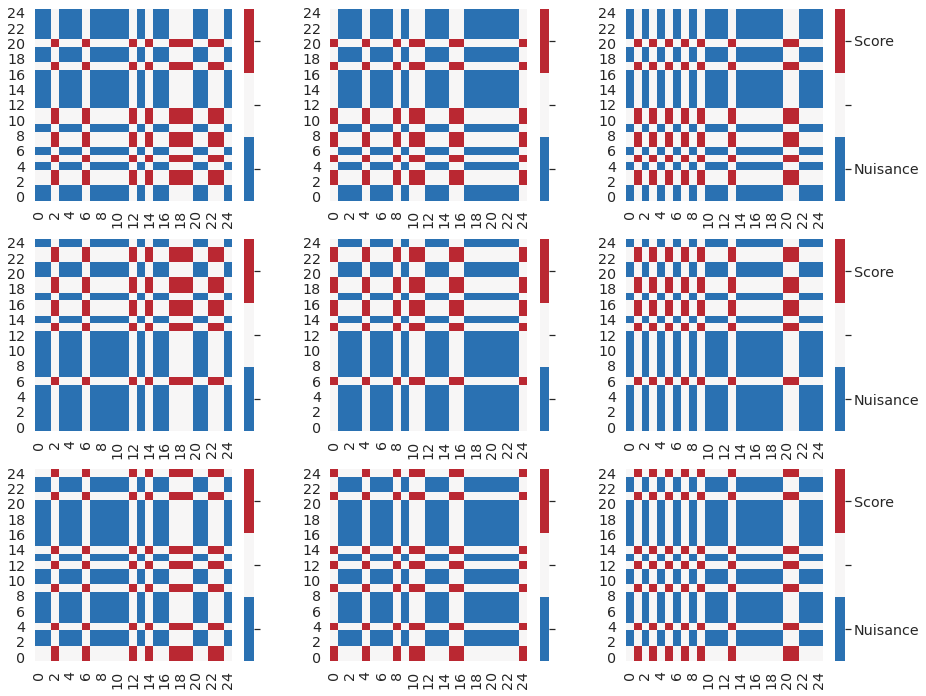

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



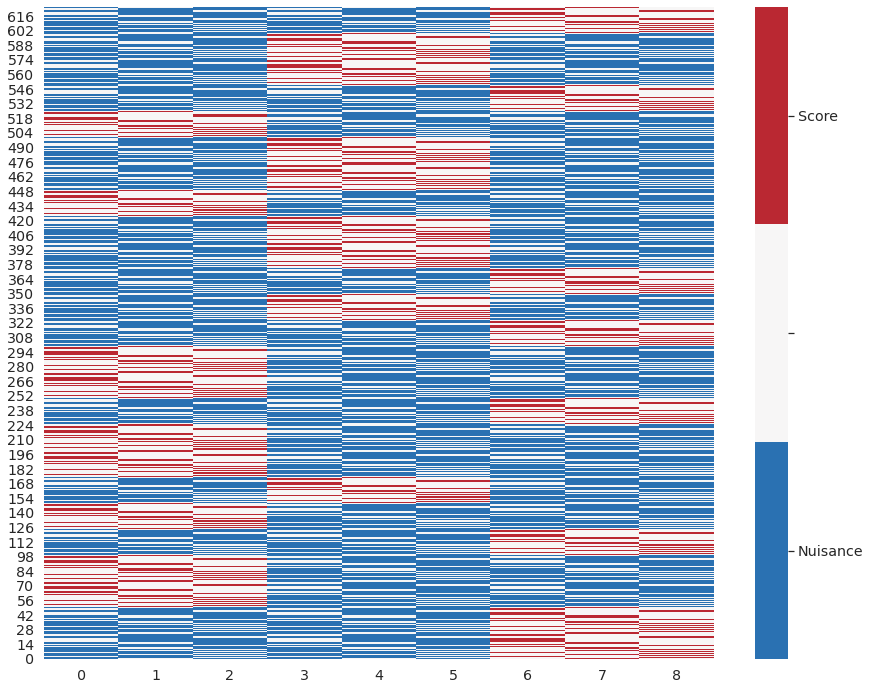

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])